In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import pysal.lib.examples as examples
import pysal.lib.weights as weights

import networkx as nx
import access

from geopy.distance import distance,geodesic

GEODATA_PATH = 'data/geodata/'
OUTPUT_PATH = 'data/output/'

In [2]:
crs_constant = "EPSG:4326"

brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
brgys_geodata = brgys_geodata.to_crs(crs_constant)

cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)

brgys_geodata["centroid"] = brgys_geodata["geometry"].centroid
print("brgys_geodata",brgys_geodata.shape)

roads_intersects = pd.read_csv(OUTPUT_PATH+'RoadsARMM_OSM2019_Intersects_Clean.csv')
roads_intersects["osm_id"] = roads_intersects["osm_id"].astype(str)

roads_geodata = gpd.read_file(OUTPUT_PATH+'RoadsARMM_OSM2019_Geodata_Clean/RoadsARMM_OSM2019_Geodata_Clean.shp')
roads_geodata = roads_geodata.to_crs(crs_constant)

roads_geodata = roads_geodata.merge(roads_intersects,on="osm_id",how="left")
print("roads_geodata",roads_geodata.shape)

schools_geodata = gpd.read_file(OUTPUT_PATH+'SchoolsDepEd2017_Geodata_Clean/SchoolsDepEd2017_Geodata_Clean.shp')
schools_geodata = schools_geodata.to_crs(crs_constant)
schools_geodata.dropna(subset=["PSGC_BRGY"],inplace=True)

cond = (schools_geodata["geometry"].x>0) &(schools_geodata["geometry"].y>0)
schools_geodata = schools_geodata[cond].reset_index(drop=True)
print("schools_geodata",schools_geodata.shape)

brgys_geodata (2489, 10)
roads_geodata (1178, 7)
schools_geodata (2533, 13)


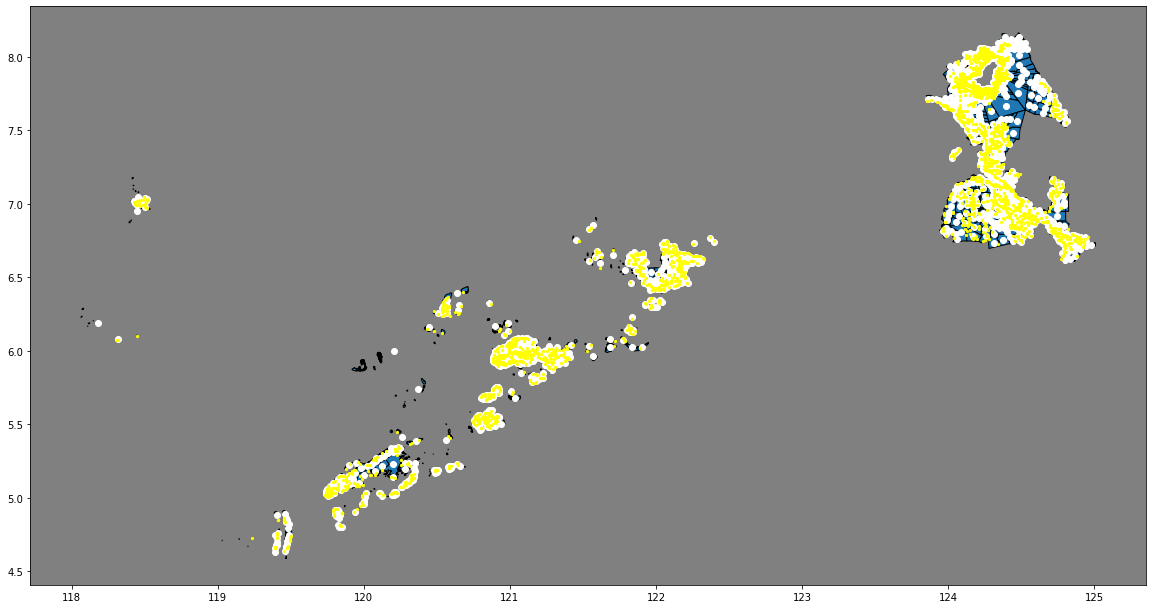

In [3]:
base = brgys_geodata.plot(figsize=(20,20),edgecolor='k')
brgys_geodata["centroid"].plot(ax=base,color="white")
schools_geodata.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

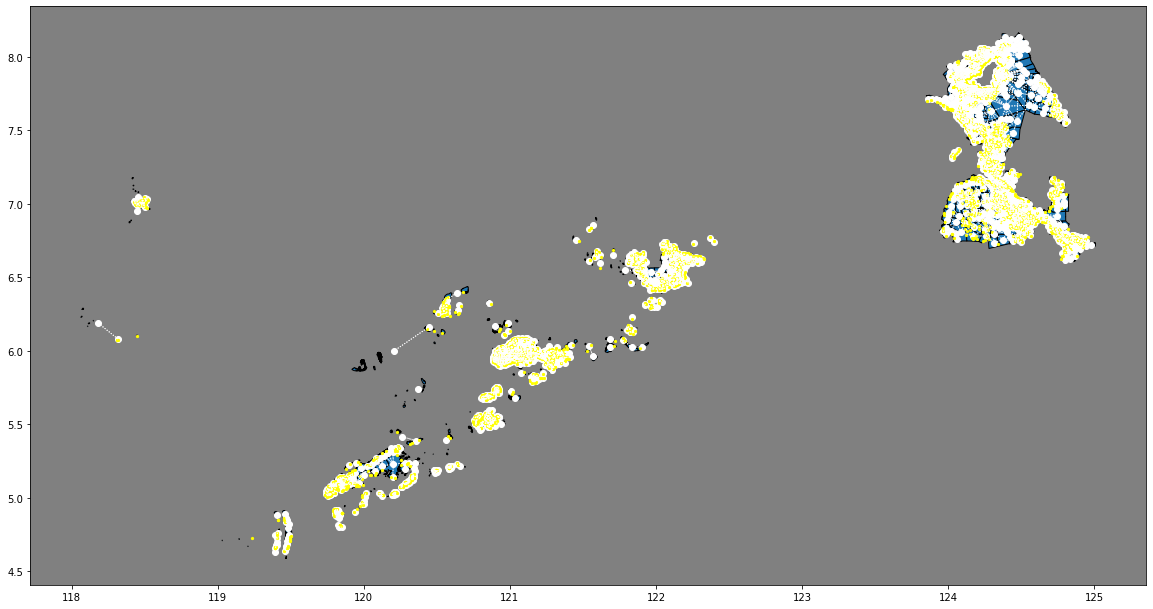

In [4]:
spatial_weights = weights.contiguity.Queen.from_dataframe(brgys_geodata)
base = brgys_geodata.plot(figsize=(20,20), edgecolor='k')
spatial_weights.plot(brgys_geodata, ax=base, 
        edge_kws=dict(color='white', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
brgys_geodata["centroid"].plot(ax=base,color="white")
schools_geodata.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

In [5]:
def get_PSGC_via_index(index,df,col):
    return df.loc[index,col]

def get_coord_values_in(index,df,col):
    lon = df.loc[index,col].x
    lat = df.loc[index,col].y
    return (lat,lon)

def get_km_dist_two_coord_series(coords1,coords2):
    dists = []
    for coord1,coord2 in zip(coords1,coords2):
        dists.append(geodesic(coord1,coord2).km)
    return dists

In [ ]:
weights_nx = spatial_weights.to_networkx()
weights_df = nx.to_pandas_edgelist(weights_nx,nodelist=list(weights_nx.nodes))
weights_df.drop(columns="weight",inplace=True)

weights_df["source_PSGC"] = weights_df["source"].apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")
weights_df["target_PSGC"] = weights_df["target"].apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")

weights_df["source_coords"] = weights_df["source"].apply(get_coord_values_in,df=brgys_geodata,col="centroid")

psgc_df = weights_df.groupby("source_PSGC",as_index=False)["target_PSGC"].apply(lambda x: "%s" % '|'.join(x))
psgc_df["target_PSGC"] = psgc_df["source_PSGC"]+"|"+psgc_df["target_PSGC"]

schools = schools_geodata[["SCH_ID","PSGC_BRGY","geometry"]]
schools.dropna(subset=["PSGC_BRGY"],inplace=True)
schools.head()

source_target_df = pd.DataFrame()

no_schools_source = []

for source,targets in psgc_df.values:
    cond = schools["PSGC_BRGY"].str.contains(targets)
    
    if (sum(cond))==0:
        no_schools_source.append(source)
        continue
    
    _sub_df = schools[cond]
    _sub_df["source_PSGC"] = source
    source_target_df = source_target_df.append(_sub_df)
    
print(len(no_schools_source),"Brgy with No schools even in neighboring Brgys")
source_target_df = source_target_df.reset_index(drop=True)
source_target_df.head()

In [ ]:
def get_coord_via_PSGC(psgc,df,psgc_col="Bgy_Code",coord_col="centroid"):
    cond = df[psgc_col].str.contains(psgc)
    lon = df.loc[cond,coord_col].x.values[0]
    lat = df.loc[cond,coord_col].y.values[0]
    return (lat,lon)

def to_coord_tuple(point):
    lon = point.x
    lat = point.y
    return (lat,lon)

In [ ]:
source_target_df["source_coords"]=source_target_df["source_PSGC"].apply(get_coord_via_PSGC,
                                                                        df=brgys_geodata)

source_target_df["target_coords"] = source_target_df["geometry"].apply(to_coord_tuple)

source_target_df["km_distance"] = get_km_dist_two_coord_series(source_target_df["source_coords"],source_target_df["target_coords"])
source_target_df

In [ ]:
cols = ["source_PSGC","SCH_ID","km_distance"]
cost_matrix = source_target_df[cols]
cost_matrix["mins_travel_time"] = 60 * cost_matrix["km_distance"]/1 #km/hour

In [ ]:
pop_brgy = pd.read_csv(OUTPUT_PATH+"Population_Schools_SDGs_Clean.csv")
pop_brgy = pop_brgy[["PSGC_BRGY","both_age_6_to_16"]]

brgys = brgys_geodata[["Bgy_Code","geometry"]]
brgys = pd.merge(brgys,pop_brgy,left_on="Bgy_Code",right_on="PSGC_BRGY",how="left")
brgys = brgys[["PSGC_BRGY","geometry","both_age_6_to_16"]]
brgys.head()

In [ ]:
base = brgys.plot(figsize=(20,20),column="both_age_6_to_16",edgecolor='k',legend=True)
schools.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

In [ ]:
brgys_w_schools = gpd.sjoin(schools, brgys[['PSGC_BRGY', 'geometry']],
                                  how='inner', op='intersects')
brgys_w_schools = brgys_w_schools.drop(columns=['index_right',"PSGC_BRGY_right"])
brgys_w_schools = brgys_w_schools.rename(columns={"PSGC_BRGY_left":"PSGC_BRGY"})
brgys_w_schools.head()

In [ ]:
school_access = access.Access(demand_df    = brgys, 
                                demand_index = 'PSGC_BRGY', 
                                demand_value = 'both_age_6_to_16',
                                supply_df    = brgys_w_schools, 
                                supply_index = 'SCH_ID',
                                cost_df      = cost_matrix, 
                                cost_origin  = 'source_PSGC', 
                                cost_dest    = 'SCH_ID',
                                cost_name    = 'mins_travel_time')

In [ ]:
gravity = access.weights.gravity(scale = 60, alpha = -1)
school_access.weighted_catchment(name = "gravity", weight_fn = gravity)

In [ ]:
def plot_access_measure(access_metric):
    _map = brgys[["PSGC_BRGY","geometry"]].set_index('PSGC_BRGY').join(school_access.access_df, how = "inner")
    base = _map.plot(access_metric, legend = True, 
                         figsize = (20, 20),  
                         alpha = 1,
                         vmin = _map[access_metric].quantile(0.05), vmax = _map[access_metric].quantile(0.95))
    schools.plot(ax=base, markersize=7, color='yellow')

In [ ]:
plot_access_measure('gravity_value')

In [ ]:
school_access_df = school_access.access_df.dropna()
school_access_df.reset_index(inplace=True)
school_access_df.columns = ["PSGC_BRGY","Student_Popn_6_to_16","Access_Score"]
school_access_df.to_csv(OUTPUT_PATH+"Model_Access_Scores_General.csv",index=False)
school_access_df.head()